# Supervised Learning - House Price Prediction



## Introduction

Vietnam is a developing country in Southeast Asia, with a population of about 100 million people and is one of the fastest growing economies in recent years. Along with rapid economic development and urbanization, housing price is also increased repidly and become too expensive for most people. Housing price is always one of the issues of great concern to many families.

In this assignment, I'm going to build a simple supervised learning model to predict housing prices in Ho Chi Minh city, the economic and largest city in Vietnam. For the purpose of price prediction, I'm going to use sklearn regression methods. Various analytical techniques are also used to explore and clean data.

### About the dataset:

I will be using the  **'House Price Prediction Dataset Vietnam - 2024'** dataset which was downloaded from Kaggle (https://www.kaggle.com/datasets/nguyentiennhan/vietnam-housing-dataset-2024/data) for the purpose of this study.

According to the dataset description from Kaggle's website: This dataset contains information about various housing properties in Vietnam. It includes detailed attributes of each property, such as its location, physical characteristics, and legal and furnishing status, along with the price. 

The data was crawled from batdongsan.vn, which is one of the largest real estate listing websites in Vietnam.

Features:
* Address: The complete address of the property, including details such as the project name, street, ward, district, and city.
* Area: The total area of the property, measured in square meters.
* Frontage: The width of the front side of the property, measured in meters.
* Access Road: The width of the road providing access to the property, measured in meters.
* House Direction: The cardinal direction the front of the house is facing (e.g., East, West, North, South).
* Balcony Direction: The cardinal direction the balcony is facing.
* Floors: The total number of floors in the property.
* Bedrooms: The number of bedrooms in the property.
* Bathrooms: The number of bathrooms in the property.
* Legal Status: Indicates the legal status of the property, such as whether it has a certificate of ownership or is under a sale contract.
* Furniture State: Indicates the state of furnishing in the property, such as fully furnished, partially furnished, or unfurnished.

Target: 
* Price: The price of the property, represented in billions of Vietnamese Dong (VND).

### GitHub repository

[https://github.com/dongndp/csca-5622](https://github.com/dongndp/csca-5622)

In [14]:
# type: ignore
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Initial Exploration & Data Cleaning

In [15]:
# Loading data
try:
    df = pd.read_csv('data/vietnam_housing_dataset.csv')
except FileNotFoundError:
    # Dataset file not found in data folder. Try to download from my github repo.
    url = "https://raw.githubusercontent.com/dongndp/csca-5622/refs/heads/main/data/vietnam_housing_dataset.csv"
    df = pd.read_csv(url)
# Replace all spaces in colum names with hyphens
df.columns = df.columns.str.replace(" ", "_")
# Display information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30229 entries, 0 to 30228
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Address            30229 non-null  object 
 1   Area               30229 non-null  float64
 2   Frontage           18665 non-null  float64
 3   Access_Road        16932 non-null  float64
 4   House_direction    8990 non-null   object 
 5   Balcony_direction  5246 non-null   object 
 6   Floors             26626 non-null  float64
 7   Bedrooms           25067 non-null  float64
 8   Bathrooms          23155 non-null  float64
 9   Legal_status       25723 non-null  object 
 10  Furniture_state    16110 non-null  object 
 11  Price              30229 non-null  float64
dtypes: float64(7), object(5)
memory usage: 2.8+ MB


First observations: The dataset contains 30229 samples, 11 features and 1 target variable. Among the 11 features, there are 6 numeric and 5 categorical features. 
There are many features with missing values. Let's look at a few rows.

In [16]:
# Listing first few rows
df.head()

,Address,Area,Frontage,Access_Road,House_direction,Balcony_direction,Floors,Bedrooms,Bathrooms,Legal_status,Furniture_state,Price
0,"Dự án The Empire - Vinhomes Ocean Park 2, Xã L...",84.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,Have certificate,NaN,8.60
1,"Dự án The Crown - Vinhomes Ocean Park 3, Xã Ng...",60.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,7.50
2,"Dự án The Crown - Vinhomes Ocean Park 3, Xã Ng...",90.0,6.0,13.0,Đông - Bắc,Đông - Bắc,5.0,NaN,NaN,Sale contract,NaN,8.90
3,"Đường Nguyễn Văn Khối, Phường 11, Gò Vấp, Hồ C...",54.0,NaN,3.5,Tây - Nam,Tây - Nam,2.0,2.0,3.0,Have certificate,Full,5.35
4,"Đường Quang Trung, Phường 8, Gò Vấp, Hồ Chí Minh",92.0,NaN,NaN,Đông - Nam,Đông - Nam,2.0,4.0,4.0,Have certificate,Full,6.90


In [17]:
# Let's see more detail about address
for i in range(5):
    print(df['Address'][i])

Dự án The Empire - Vinhomes Ocean Park 2, Xã Long Hưng, Văn Giang, Hưng Yên
Dự án The Crown - Vinhomes Ocean Park 3, Xã Nghĩa Trụ, Văn Giang, Hưng Yên
Dự án The Crown - Vinhomes Ocean Park 3, Xã Nghĩa Trụ, Văn Giang, Hưng Yên
Đường Nguyễn Văn Khối, Phường 11, Gò Vấp, Hồ Chí Minh
Đường Quang Trung, Phường 8, Gò Vấp, Hồ Chí Minh


From the result, the Address field is a combination of the construction project name, buldings, street, town/ward, city/district and city/province separated by commas (,). I'm going to remove all house entries that are not located in Ho Chi Minh city (since I just want to predict house prices in Ho Chi Minh city only) and create new column District and then drop the original Address column as I don't need it anymore.

In [18]:
df = df[df['Address'].str.split(", ").str[-1].str.replace(".", "") == "Hồ Chí Minh"]
df['District'] = df['Address'].str.split(", ").str[-2].str.replace(".", "")
df.drop('Address', inplace = True, axis = 1)

In [19]:
# Now I want to look at 'District'
df['District'].value_counts()

District
Gò Vấp                       1372
Bình Tân                     1157
Thủ Đức                      1145
Tân Phú                      1015
Quận 12                       939
Bình Thạnh                    851
Tân Bình                      850
Quận 9                        710
Quận 7                        642
Quận 8                        446
Phú Nhuận                     376
Nhà Bè                        359
Quận 10                       293
Quận 6                        246
Hóc Môn                       244
Quận 3                        221
Bình Chánh                    208
Quận 2                        195
Quận 4                        139
Quận 11                       136
Quận 1                        104
Quận 5                         60
Củ Chi                         43
Thành phố Thủ Đức               9
Quận Bình Tân                   4
 Quận 9                         3
Quận Tân Bình                   2
Quận Tân Phú                    1
Cần Giờ                         1
Gò Vấ

I'm going to drop all districts which have less than 10 entries. I believe the district name of these entries are not input correctly. 

In [20]:
min_district_samples = 10

unique_districts = df['District'].value_counts()
unique_districts = unique_districts[unique_districts >= min_district_samples].index
df = df[df['District'].isin(unique_districts)]

In [21]:
# Check null/missing values
df.isnull().sum()

Area                     0
Frontage              4595
Access_Road           4504
House_direction       8600
Balcony_direction    10067
Floors                1354
Bedrooms              1589
Bathrooms             2105
Legal_status          1870
Furniture_state       5651
Price                    0
District                 0
dtype: int64

In [22]:
# Inspect house direction feature
df['House_direction'].value_counts()

House_direction
Đông - Nam    599
Đông - Bắc    424
Tây - Nam     417
Tây - Bắc     368
Đông          364
Tây           358
Bắc           319
Nam           302
Name: count, dtype: int64

In [23]:
# Check balcony direction
df['Balcony_direction'].value_counts()

Balcony_direction
Đông - Nam    294
Tây - Nam     228
Đông - Bắc    222
Đông          200
Tây - Bắc     191
Nam           188
Tây           183
Bắc           178
Name: count, dtype: int64

The House and Balcony direction are categorical features. They indicate the cardinal direction of the house such as East (Đông), West (Tây), South (Nam), North (Bắc), South - East (Đông Nam), North - West (Tây Bắc), etc. While house orientation is one of the factors that influence buyers' decisions, it has little or no impact on home prices. And since there are so many missing values, I decide to drop these two features.

In [24]:
# Drop House/Balcony direction features
df.drop('House_direction', inplace = True, axis = 1)
df.drop('Balcony_direction', inplace = True, axis = 1)

It seems not make sense for a house or apartment with zero floor, bedroom, bathroom or no access road... So for any numeric feature, I'm going to fill the missing value with the median. Likewise for any categorical feature, I'm going to fill the missing value with the mode.

In [25]:
# Fill missing values
for col in ['Floors', 'Frontage', 'Access_Road', 'Bedrooms', 'Bathrooms']: 
    fill_value = df[col].median()
    df.fillna({col: fill_value}, inplace=True)

for col in ['Legal_status', 'Furniture_state']:
    fill_value = df[col].mode()
    df.fillna({col: fill_value[0]}, inplace=True)

In [26]:
#Reset index
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11751 entries, 0 to 11750
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             11751 non-null  float64
 1   Frontage         11751 non-null  float64
 2   Access_Road      11751 non-null  float64
 3   Floors           11751 non-null  float64
 4   Bedrooms         11751 non-null  float64
 5   Bathrooms        11751 non-null  float64
 6   Legal_status     11751 non-null  object 
 7   Furniture_state  11751 non-null  object 
 8   Price            11751 non-null  float64
 9   District         11751 non-null  object 
dtypes: float64(7), object(3)
memory usage: 918.2+ KB


### Summary of Initial Exploration and Data Cleaning

The original dataset contains 30.227 samples, 11 features. There are many entries with null values.

What I have done so far:
* Remove all house entries which are not located in Ho Chi Minh city since I want to predict the housing prices in Ho Chi Minh city only.
* Remove all features that contain too many null values and does not make sense to keep them, including the House and Balcony orientations.
* Fill all missing values with the median (for numerical features) and the mode (for categorical features)

After all of above cleaning tasks, now I have a clean dataset which contains 11.751 samples of listing houses in Ho Chi Minh city, each has 9 features: Area, Frontage, Access Road, Floors, Number of Bedrooms, Number of Bathrooms, Legal status, Furniture state, and District where it's located. 

## Exploratory Data Analysis


Above, I assumed that house prices vary by province and district. I'm going to check if the data supports my hypothesis.

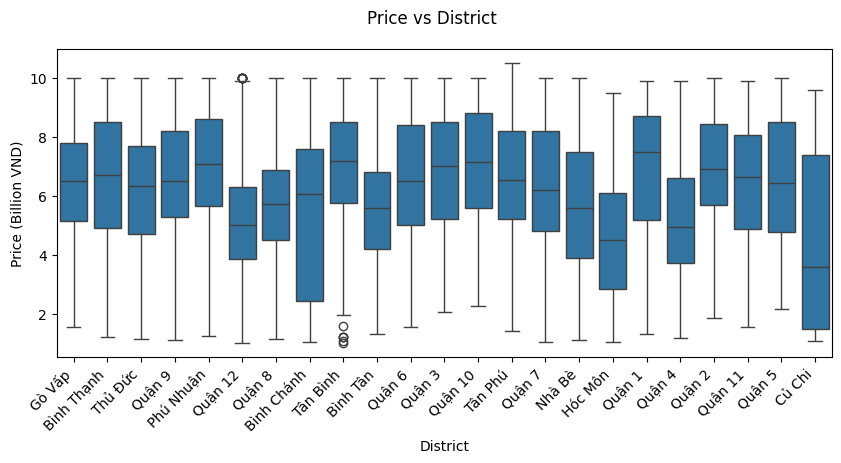

In [27]:
# Draw a box plot to see if house prices vary by district
fig, ax = plt.subplots(figsize=(10, 4))
fig.suptitle('Price vs District')
sns.boxplot(x='District', y='Price', data=df, ax=ax)
ax.set(ylabel='Price (Billion VND)', xlabel='District')
plt.xticks(rotation=45, ha='right')
plt.show()

From the box plot results above, I can conclude that the data supports my assumption. A house located in downtown (Quận 1) or new areas such as Quận 2 tend to be higher than on located in surbubs such as Củ Chi or Bình Chánh.

From the plot, there are some outliers. I assume that these are true ouliers and I'm not going to remove them.

### Price Distribution

Now I want to see how the distribution of prices looks like.

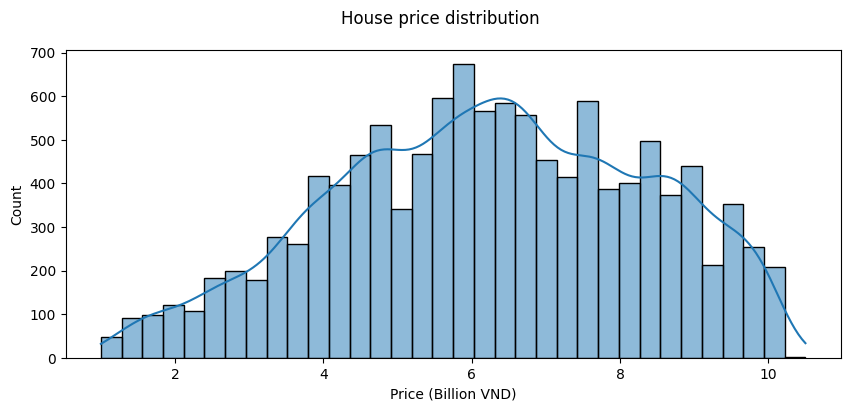

In [28]:
# Display the distribution of prices
fig, ax = plt.subplots(figsize=(10, 4))
fig.suptitle('House price distribution')
sns.histplot(df['Price'], kde=True, ax=ax)
ax.set(xlabel='Price (Billion VND)', ylabel='Count')
plt.show()

The distribution of prices looks a little bit skewed.

### Correlation Heatmap

 Let's view the correlation heatmap

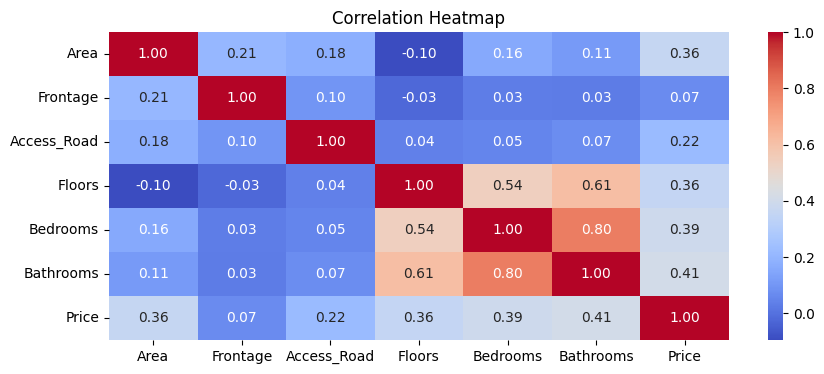

In [29]:
# Select numerical columns and display the correlation heatmap
df1 = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 4))
sns.heatmap(df1.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

The heatmap shows that Bathrooms, Bedrooms, Floors and Areas are correlated with the target variable, but not strongly. It also shows that Bathrooms and Bedrooms are strongly correlated (0.80), Bathrooms and Floors (0.61), Bedrooms and Floors (0.54) are also correlated with each others.

### Summary of EDA

What I've found so far:

* The house prices vary by areas, houses located in the downtown or new areas are higher than in the surbubs
* The price distribution of house prices is a bit skewed
* Bathrooms, Bedrooms Floors, and Area are correlated with the price, but not strongly, while Fontage isn't.
* Bathrooms and Bedrooms are strongly correlated, Bathrooms and Floors, Bedrooms and Floors are also correlated with each others.

## Models

### Convert categorical variables to numerical variables and prepare train and test dataset

In [30]:
from sklearn.model_selection import train_test_split

# Converts categorical variables into dummy/indicator variables
df = pd.get_dummies(df, drop_first=True, dtype=int)

# split into train and test dataset
X = df.drop(columns=['Price'])
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

lr_model = LinearRegression().fit(X_train, y_train)
lr_score = lr_model.score(X_test, y_test)
lr_y_pred = lr_model.predict(X_test)
lr_rmse = root_mean_squared_error(y_test, lr_y_pred)
lr_residuals = y_test - lr_y_pred
print(f"Score: {lr_score:.2f}, RMSE: {lr_rmse:.2f}")

Score: 0.52, RMSE: 1.44


### RandomForest Regressor

The linear regression model gave the score of 0.52 and RMSE=1.44. In the following I'm going to use RandomForest Regressor to see if it can provide better score. I also try to use GridSearchCV to test the hyper-parameters and see which is the best choice of hyper-parameters that gives the highest score.

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {'max_depth': [1, 5, 10, 15, 20, 25, 30]}
base_estimator = RandomForestRegressor(max_features='sqrt')
clf = GridSearchCV(base_estimator, param_grid, cv=5).fit(X_train, y_train)
rf_model = clf.best_estimator_
rf_params = clf.best_params_
rf_score = rf_model.score(X_test, y_test)
rf_y_pred = rf_model.predict(X_test)
rf_residuals = y_test - rf_y_pred
rf_rmse = root_mean_squared_error(y_test, rf_y_pred)
print(f"Best params: {rf_params}, Best score: {rf_score:.2f}, Best RMSE: {rf_rmse:.2f}")

Best params: {'max_depth': 25}, Best score: 0.64, Best RMSE: 1.25


As the result shown, the RandomForest Regressor model gave a score of 0.64 and RMSE=1.25 which is much better than previous Linear Regression model.

### Residual Plot

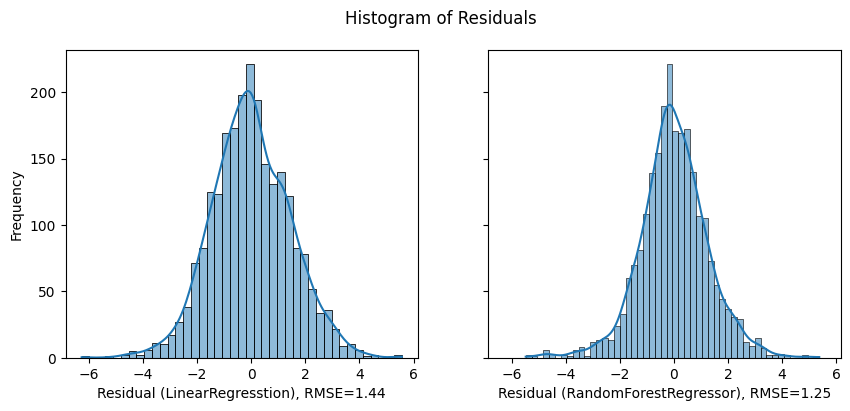

In [33]:
# Plot residuals
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 4))
fig.suptitle('Histogram of Residuals')
sns.histplot(lr_residuals, kde=True, ax=ax1)
ax1.set(xlabel=f'Residual (LinearRegresstion), RMSE={lr_rmse:.2f}', ylabel='Frequency')
sns.histplot(rf_residuals, kde=True, ax=ax2)
ax2.set(xlabel=f'Residual (RandomForestRegressor), RMSE={rf_rmse:.2f}')
plt.show()

### Predicted vs Actual values plot

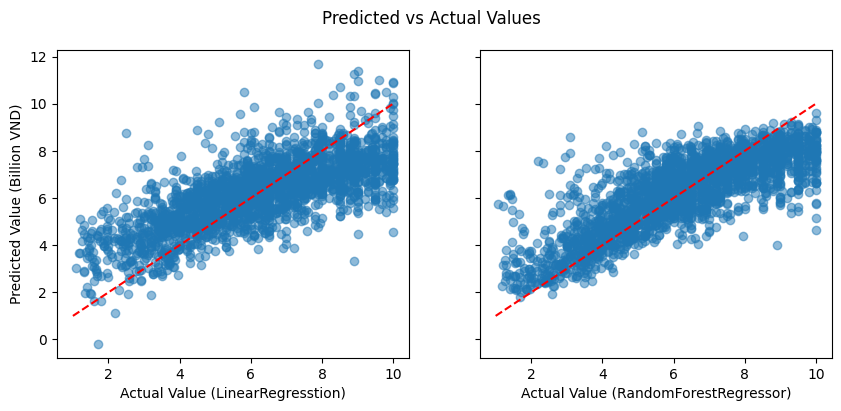

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 4))
fig.suptitle('Predicted vs Actual Values')
ax1.scatter(y_test, lr_y_pred, alpha=0.5)
ax1.plot([1, 10], [1, 10], 'r--')
ax1.set(xlabel='Actual Value (LinearRegresstion)', ylabel='Predicted Value (Billion VND)')
ax2.scatter(y_test, rf_y_pred, alpha=0.5)
ax2.plot([1, 10], [1, 10], 'r--')
ax2.set(xlabel='Actual Value (RandomForestRegressor)')
plt.show()

## Summary

In this exercise, I explored the Vietnam housing price dataset, picked up houses in Ho Chi Minh city, performed data cleaning tasks such as removing features that have too many missing values or fill missing values with median/mode value. 

During EDA, I looked at the data distribution, I assumed the outliers are true outliers and decided to not removing them. I plotted the correlation heatmap and analyzed the correlation between features and target variable. 

I prepared the data before test my models by converting all categorical features to numerical and then splitted the data into train and test datasets. 

Finally, I tested with 2 sklearn's regression models: LinearRegresstion and RandomForestRegressor. For the later model, I also tried different values of hyper-parameters using GridSearchCV() to find the model that gives the highest score. As the result shown, RandomForestRegressor gives the score of 0.64 which is much better than LinearRegression model. But I believe that the model's can be further improved by considering to remmove outliers, tunning model's hyper-parameters or exploring more models.